In [7]:
import cv2
from PIL import Image, ImageDraw, ImageFont
import pyrealsense2 as rs
import numpy as np
from vision.classification_model import ClassificationModel
from vision.segmentation_model import SegmentationModel
# from vision.vision_models import SegmentationModel, ClassificationModel
import keras
import os
import glob
from keras import backend as K
from backend_logging import get_logger
import logging
import time

In [8]:
IMG_SIZE = "img_size"
BATCH_SIZE = "batch_size"
OPTIMIZER = "optimizer"
EPOCHS = "epochs"
LOSS = "loss"
METRICS = "metrics"
LEARNING_RATE = "learning_rate"
PATIENCE = "patience"
CALLBACKS = "callbacks"
PATH = "path"

In [9]:
VISION_PATH = "vision/crops/monkey/predict"
#TODO: modify to raise instead of returns?
class VisionClient():
    def __init__(self):
        self.pipeline = None
        self.path = VISION_PATH
        self.sm = None
        self.cm = None
        self.k = None
        self.d = None
    
    def connect(self):
        self.sm = SegmentationModel()
        self.sm.load_model()
        get_logger(__name__).log(logging.INFO,
                        f"Segmentation model loaded")
        K.clear_session()
        self.cm = ClassificationModel()
        self.cm.load_model()
        get_logger(__name__).log(logging.INFO,
                            f"Classification model loaded")
        
    def init_camera_streams(self):
        # Configure depth and color streams
        self.pipeline = rs.pipeline()
        config = rs.config()

        config.enable_stream(rs.stream.depth)
        config.enable_stream(rs.stream.color)

        # Start streaming
        self.pipeline.start(config)
        sensor = self.pipeline.get_active_profile().get_device().query_sensors()[1]

        # Set the exposure anytime during the operation
        sensor.set_option(rs.option.exposure, 500.000)
        #sensor.set_option(rs.option.laser_power, 180)
        align_to = rs.stream.color
        align = rs.align(align_to)
        filters = [rs.spatial_filter(),rs.temporal_filter()]

        return align, filters

    def get_frames(self, pipeline, align, filters):
        # Wait for a coherent pair of frames: depth and color
        frames = pipeline.wait_for_frames()
        aligned_frames = align.process(frames)
        depth_frame = aligned_frames.get_depth_frame()
        for filter in filters:
            depth_frame = filter.process(depth_frame)
        depth_frame = depth_frame.as_depth_frame()
        color_frame = aligned_frames.get_color_frame()

        self.color_intrin = color_frame.profile.as_video_stream_profile().intrinsics
        self.k = np.array(((self.color_intrin.fx, 0, self.color_intrin.ppx),
                (0,self.color_intrin.fy, self.color_intrin.ppy),
                (0,0,1)))
        self.d = np.array(self.color_intrin.coeffs)
        return color_frame, depth_frame

    def get_valid_neighbors(self,coords,limits,size):
        neighbours = []
        for i in range(-size,size+1):
            for j in range(-size,size+1):
                xn, yn = coords[0]+i, coords[1]+j
                if (xn,yn) != coords:
                    if 0 <= xn < limits[0] and 0 <= yn < limits[1]:
                        neighbours.append((xn,yn))
        return neighbours

    def get_2d_points(self,mask_raw, limits, c1):
        polygon = mask_raw.xy[0]
        epsilon = 0.1 * cv2.arcLength(polygon, True)
        box = cv2.approxPolyDP(polygon, epsilon, True)
        if box.shape != (4,1,2):
            return
        box = box.reshape(4,2)
        #rect = cv2.minAreaRect(polygon)
        #box = cv2.boxPoints(rect)
        sorted_box = box[np.argsort(box[:, 0])]
        top_points = [tuple(sorted_box[0]),tuple(sorted_box[1])]
        c1.polygon(box,outline=(0,255,0),width=5)
        c1.line(top_points,fill=(255,255,0),width=5)

        top_x, top_y = np.mean(top_points, axis=0).astype(int)
        center_x, center_y = np.mean(box,axis=0).astype(int)
        
        rel_2d_points = list(sorted_box.copy())
        rel_2d_points.append([top_x,top_y])
        rel_2d_points.append([center_x,center_y])

        r = 5
        for i, (x,y) in enumerate(rel_2d_points):
            x = int(np.clip(x, 0, limits[0]-1))
            y = int(np.clip(y, 0, limits[1]-1))
            rel_2d_points[i] = [x,y]
            c1.ellipse([(x-r,y-r),(x+r,y+r)],fill=(0,0,255))
            
        return rel_2d_points

    def get_camera_3d_points(self,depth_frame, rel_2d_points, color_intrin, limits):
        rel_3d_points = []
        for x_2d,y_2d in rel_2d_points:
            depth = depth_frame.get_distance(x_2d,y_2d)
            if depth == 0:
                neighbours = self.get_valid_neighbors((x_2d,y_2d),(limits[0],limits[1]),1)
                distances = []
                for nx, ny in neighbours:
                    depth = depth_frame.get_distance(nx, ny)
                    if depth != 0:
                        distances.append(depth)
                
                if distances:
                    depth = np.median(distances)
                else:
                    depth = 0
                    print("No depths from self/neighbours could be found")

            #right: x, down: y, forward: z
            result = rs.rs2_deproject_pixel_to_point(color_intrin, [x_2d, y_2d], depth)
            """
            Camera:     Robot:
            x: down     x: left
            y: left     y: back
            z: forward  z: up

            Robot = Camera:
            x -> y
            y -> -z
            z -> -x
            """
            x_cam,y_cam,z_cam = result
            x_rob = y_cam
            y_rob = -z_cam
            z_rob = -x_cam

            rel_3d_points.append([x_rob,y_rob,z_rob])
        return rel_3d_points

    def show_3d_points(self,points_3d, rot, trans, k, d, c1):
        for point_3d in points_3d:
            point_3d = np.array(point_3d,dtype=np.float64)
            point_2d, jacobian = cv2.projectPoints(point_3d, rot, trans, k, d)
            x,y = tuple(point_2d.flatten())
            r=5
            c1.ellipse([(x-r,y-r),(x+r,y+r)],fill=(0,255,255))
            #c1.text((x,y),f"{point_3d}")

    def calculate_rotational_angles(self,plane_coordinates): #TODO: maybe modify
        # Extracting the coordinates of the plane
        p1, p2, p3, p4 = plane_coordinates

        # Calculate vectors along two edges of the plane
        v1 = np.array(p2) - np.array(p1)
        v2 = np.array(p3) - np.array(p1)

        # Calculate the cross product to get the normal vector of the plane
        normal_vector = np.cross(v1, v2)
        # Normalize the normal vector
        normal_vector /= np.linalg.norm(normal_vector)

        # Calculate angles around x, y, and z axes (Euler angles)
        x_angle = np.arctan2(normal_vector[2], normal_vector[1])
        y_angle = np.arctan2(-normal_vector[0], np.sqrt(normal_vector[1]**2 + normal_vector[2]**2))
        z_angle = np.arctan2(v2[0], v1[0])

        # Convert angles from radians to degrees
        x_angle_deg = np.degrees(x_angle)
        y_angle_deg = np.degrees(y_angle)
        z_angle_deg = np.degrees(z_angle)

        return x_angle_deg, y_angle_deg, z_angle_deg

    def get_robot_coords(self, camera_coords):
        R = np.array([[0.98965,0.14059,-0.028841],
                    [-0.14345,0.97505,-0.16939],
                    [0.0043076,0.17177,0.98513]])
        t = np.array([0.18212,0.11633,0.38649])
        new_coords = np.dot(R,camera_coords) + t

        return new_coords

    def get_pickup_locations(self):
        d3_coords = []
        align, filters = self.init_camera_streams()
        try:
            while True:
                color_frame, depth_frame = self.get_frames(self.pipeline, align, filters)
                if not depth_frame or not color_frame:
                    continue
            
                color_image = np.asanyarray(color_frame.get_data())
                img_color = Image.fromarray(color_image)
                img_color.save("vision/input_color.jpg")

                results = self.sm.predict(color_image,False,True,True)
                classes, conf_list = self.cm.predict(self.path+"/crops/Crate/")
                data_image = Image.open(self.path+"/image0.jpg") #seg prediction results
                color_draw = ImageDraw.Draw(data_image)
                depth_image = np.asanyarray(depth_frame.get_data())
                min_depth = 850  # Minimum depth value
                max_depth = 1700  # Maximum depth value
                depth_image_clipped = np.clip(depth_image, min_depth, max_depth)
                normalized_depth = (depth_image_clipped - min_depth) / (max_depth - min_depth)
                depth_colormap = cv2.applyColorMap((normalized_depth * 255).astype(np.uint8), cv2.COLORMAP_JET)
                cv2.imwrite("vision/depth.jpg", depth_colormap)

                masks = results[0].masks
                #for mask_raw, label in zip(masks,classes): #do classification result interpretation
                for (mask_raw,cls) in zip(masks,classes):        
                    rel_2d_points = self.get_2d_points(mask_raw, data_image.size, color_draw)
                    if not rel_2d_points:
                        print("Box has incorrect shape -> no crate")
                        continue

                    rel_3d_points = self.get_camera_3d_points(depth_frame, rel_2d_points, self.color_intrin,data_image.size)
                    success, rot, trans = cv2.solvePnP(np.array(rel_3d_points).astype("float32"),np.array(rel_2d_points).astype("float32"),self.k,self.d)
                    self.show_3d_points(rel_3d_points[:4],rot, trans, self.k, self.d, color_draw)

                    robot_coords = []
                    for coord in rel_3d_points[:4]:
                        rob_coord = self.get_robot_coords(coord)
                        robot_coords.append(rob_coord)
            
                    x,y,z = self.get_robot_coords(rel_3d_points[4])
                    rx,ry,rz = self.calculate_rotational_angles(robot_coords)
                    d3_coords.append({"coords":(x,y,z,rx,ry,rz),"class":cls})
                    point = tuple(round(c,5) for c in (x,y,z,rx,ry,rz))
                    print("Robot_point:",point)
                    color_draw.text(rel_2d_points[4], f"{cls,x,y,z,rx,ry,rz},{cls}", fill=(255,255,255))
                    
                #data_image.show()
                data_image.save("vision/distance_annot.jpg")
                files = glob.glob(os.path.join(self.path, '**/*.jpg'), recursive=True) #TODO: move outside of vision function
                for f in files:
                    os.remove(f)
                break
            return d3_coords
        except Exception as e:
            print(e)
            pass
        finally:
            self.pipeline.stop()
    
    def get_valid_pickup_loc(self):
        results = self.get_pickup_locations()
        """
        Goal:
        - Remove invalid results (limits & NoCrate)
        - Search for highest crate
        - If PickupCrate - return coords
        - If NoPickupCrate - return assistance message
        """
        val_results = []
        for res in results:
            coords = res["coords"]
            cls = res["class"]
            if not -1.5 < coords[0] < 1.5 or not -1.6 < coords[1] < -0.6 or coords[2] > 1:
                print("Coords not within limits!, Result ignored")
                continue
            elif cls == "NoCrate":
                print("Ignored due to NoCrate class")
            else:
                val_results.append(res)
        
        if val_results:
            def get_coord_2(item):
                return item["coords"][2]
            highest_entry = max(val_results, key=get_coord_2)

            if highest_entry["class"] == "NoPickupCrate":
                return "NoPickupCrate",highest_entry["class"]
            else:
                self.get_crate_height(highest_entry["coords"]) #TODO
                return highest_entry["coords"]
        else:
            return "No valid results"
    
    def get_crate_height(self,coords):
        pass

In [13]:
vision = VisionClient()
vision.connect()

In [14]:
vision.get_valid_pickup_loc()


0: 384x640 3 Crates, 194.6ms
Speed: 1.9ms preprocess, 194.6ms inference, 0.0ms postprocess per image at shape (1, 3, 384, 640)
Results saved to vision\crops\monkey\predict
1/1 [==============================] - 0s 26ms/step
Robot_point: (-0.15157, -0.89374, -0.34829, 175.53895, 0.72644, -134.2527)
Robot_point: (-0.17534, -1.01843, -0.01109, -8.80438, 1.08913, -5.73659)
Robot_point: (0.19964, -1.00784, -0.31404, 6.78037, 3.43819, 2.81959)


(-0.1753387231684625,
 -1.0184257440808415,
 -0.011093732099688058,
 -8.80437993469011,
 1.0891265710238327,
 -5.736585820101864)

# Segmentation Model

This model is responsible for extracting crate front segments out of the picture of the entire carrier. These crops are then saved and forwarded to the classification model, as well as used for the pickup-point calculation.

In [14]:
segment_model = SegmentationModel()

In [17]:
seg_params = {
    PATH: "./vision/data/no-bars_no-classes_v2/data.yaml",
    IMG_SIZE: 640,
    OPTIMIZER: "AdamW",
    LEARNING_RATE: 0.0015,
    EPOCHS: 80,
    BATCH_SIZE: 8,
    PATIENCE: 10
}

In [13]:
#load previously trained model
segment_model.load_model()

In [18]:
#train model
segment_model.train(seg_params)

Ultralytics YOLOv8.0.227 🚀 Python-3.10.11 torch-2.1.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
engine\trainer: task=segment, mode=train, model=vision/yolov8s-seg.pt, data=./vision/data/no-bars_no-classes/data.yaml/data.yaml, epochs=80, patience=10, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train20, exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=True, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_c

RuntimeError: Dataset 'vision/data/no-bars_no-classes/data.yaml/data.yaml' error  './vision/data/no-bars_no-classes/data.yaml/data.yaml' does not exist

In [ ]:
#evaluate model
segment_model.test()

In [ ]:
#try model out on image(s)
results = segment_model.predict(seg_params[PATH]+"/test/images")

# Classification Model
This model is used to take cropped images of crate fronts and classify them by their pickup method. These classifications will then be combined to determine pickup point

In [11]:
class_model = ClassificationModel()

In [12]:
#load previous model
class_model.load_model()

1/1 [==============================] - 0s 328ms/step
Predicted class: NoCrate, 85.59 confidence.
Real class: NoCrate
1/1 [==============================] - 0s 31ms/step
Predicted class: NoCrate, 91.35 confidence.
Real class: NoCrate
1/1 [==============================] - 0s 23ms/step
Predicted class: NoPickupCrate, 100.00 confidence.
Real class: PickupCrate
1/1 [==============================] - 0s 29ms/step
Predicted class: NoPickupCrate, 99.91 confidence.
Real class: PickupCrate
1/1 [==============================] - 0s 24ms/step
Predicted class: NoPickupCrate, 100.00 confidence.
Real class: PickupCrate
1/1 [==============================] - 0s 25ms/step
Predicted class: NoPickupCrate, 100.00 confidence.
Real class: PickupCrate
1/1 [==============================] - 0s 22ms/step
Predicted class: NoPickupCrate, 100.00 confidence.
Real class: PickupCrate
1/1 [==============================] - 0s 25ms/step
Predicted class: NoPickupCrate, 100.00 confidence.
Real class: PickupCrate
1/1 [=

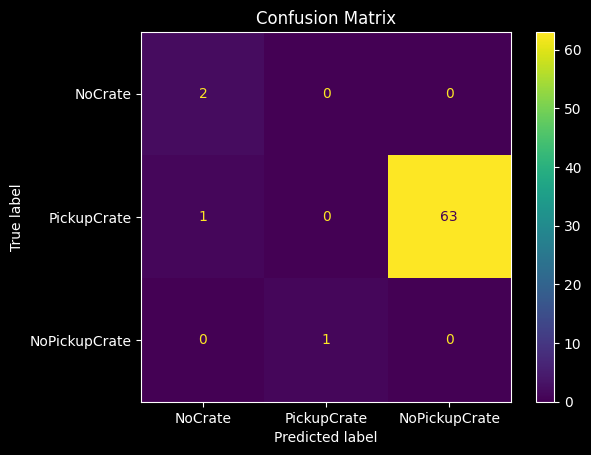

In [13]:
#evaluate model
class_model.test()

# Complete Pipeline

### Connect to camera

### Load models

In [2]:
from keras import backend as K

K.clear_session()

In [3]:
sm = SegmentationModel()
sm.load_model()

In [4]:
cm = ClassificationModel()
cm.load_model()

### Combine stream

In [5]:
def init_camera_streams():
    # Configure depth and color streams
    pipeline = rs.pipeline()
    config = rs.config()

    config.enable_stream(rs.stream.depth)
    config.enable_stream(rs.stream.color)

    # Start streaming
    pipeline.start(config)
    sensor = pipeline.get_active_profile().get_device().query_sensors()[1]

    # Set the exposure anytime during the operation
    sensor.set_option(rs.option.exposure, 500.000)
    #sensor.set_option(rs.option.laser_power, 180)
    align_to = rs.stream.color
    align = rs.align(align_to)

    font = ImageFont.truetype("vision/data/Arial.ttf", 40)
    filters = [rs.spatial_filter(),rs.temporal_filter()]
    return pipeline, align, filters, font

def get_frames(pipeline, align, filters):
    # Wait for a coherent pair of frames: depth and color
    frames = pipeline.wait_for_frames()
    aligned_frames = align.process(frames)
    depth_frame = aligned_frames.get_depth_frame()
    for filter in filters:
        depth_frame = filter.process(depth_frame)
    depth_frame = depth_frame.as_depth_frame()
    color_frame = aligned_frames.get_color_frame()

    color_intrin = color_frame.profile.as_video_stream_profile().intrinsics
    k = np.array(((color_intrin.fx, 0, color_intrin.ppx),
            (0,color_intrin.fy, color_intrin.ppy),
            (0,0,1)))
    d = np.array(color_intrin.coeffs)
    return color_frame, depth_frame, k, d, color_intrin

def get_valid_neighbors(coords,limits,size):
    neighbours = []
    for i in range(-size,size+1):
        for j in range(-size,size+1):
            xn, yn = coords[0]+i, coords[1]+j
            if (xn,yn) != coords:
                if 0 <= xn < limits[0] and 0 <= yn < limits[1]:
                    neighbours.append((xn,yn))
    return neighbours

def get_2d_points(mask_raw, limits, c1):
    polygon = mask_raw.xy[0]
    epsilon = 0.1 * cv2.arcLength(polygon, True)
    box = cv2.approxPolyDP(polygon, epsilon, True)
    if box.shape != (4,1,2):
        return
    box = box.reshape(4,2)
    #rect = cv2.minAreaRect(polygon)
    #box = cv2.boxPoints(rect)
    sorted_box = box[np.argsort(box[:, 0])]
    top_points = [tuple(sorted_box[0]),tuple(sorted_box[1])]
    c1.polygon(box,outline=(0,255,0),width=5)
    c1.line(top_points,fill=(255,255,0),width=5)

    top_x, top_y = np.mean(top_points, axis=0).astype(int)
    center_x, center_y = np.mean(box,axis=0).astype(int)
    
    rel_2d_points = list(sorted_box.copy())
    rel_2d_points.append([top_x,top_y])
    rel_2d_points.append([center_x,center_y])

    r = 5
    for i, (x,y) in enumerate(rel_2d_points):
        x = int(np.clip(x, 0, limits[0]-1))
        y = int(np.clip(y, 0, limits[1]-1))
        rel_2d_points[i] = [x,y]
        c1.ellipse([(x-r,y-r),(x+r,y+r)],fill=(0,0,255))
        
    return rel_2d_points

def get_camera_3d_points(depth_frame, rel_2d_points, color_intrin, limits):
    rel_3d_points = []
    for x_2d,y_2d in rel_2d_points:
        depth = depth_frame.get_distance(x_2d,y_2d)
        if depth == 0:
            neighbours = get_valid_neighbors((x_2d,y_2d),(limits[0],limits[1]),1)
            distances = []
            for nx, ny in neighbours:
                depth = depth_frame.get_distance(nx, ny)
                if depth != 0:
                    distances.append(depth)
            
            if distances:
                depth = np.median(distances)
            else:
                depth = 0
                print("No depths from self/neighbours could be found")

        #right: x, down: y, forward: z
        result = rs.rs2_deproject_pixel_to_point(color_intrin, [x_2d, y_2d], depth)
        """
        Camera:     Robot:
        x: down     x: left
        y: left     y: back
        z: forward  z: up

        Robot = Camera:
        x -> y
        y -> -z
        z -> -x
        """
        x_cam,y_cam,z_cam = result
        x_rob = y_cam
        y_rob = -z_cam
        z_rob = -x_cam

        rel_3d_points.append([x_rob,y_rob,z_rob])
    return rel_3d_points

def draw_angle_lines(rel_3d_points,rot,trans,k,d,c1):
    line1_points = [tuple(rel_3d_points[0]),tuple(rel_3d_points[1])]
    line2_points = [tuple(rel_3d_points[0]),tuple(rel_3d_points[2])]
    line1_vec = np.array(line1_points[1]) - np.array(line1_points[0])
    line2_vec = np.array(line2_points[1]) - np.array(line2_points[0])
    normal_vector = np.cross(line1_vec, line2_vec)
    normal_vector_unit = normal_vector / np.linalg.norm(normal_vector)
    point_on_vector = normal_vector_unit * 0.1
    line3_points = [tuple(rel_3d_points[0]),tuple(point_on_vector)]
    points = line1_points + line2_points + line3_points

    displayed_points = []
    for point in points:
        point_2d, jacobian = cv2.projectPoints(np.array(point), rot, trans, k, d)
        displayed_points.append(tuple(point_2d.flatten()))
    
    tuples_list = [(displayed_points[i], displayed_points[i + 1]) for i in range(0, len(displayed_points) - 1, 2)]
    
    for points in tuples_list:
        c1.line(points,fill=(255,255,255),width=5)

def show_3d_points(points_3d, rot, trans, k, d, c1):
    for point_3d in points_3d:
        point_3d = np.array(point_3d,dtype=np.float64)
        point_2d, jacobian = cv2.projectPoints(point_3d, rot, trans, k, d)
        x,y = tuple(point_2d.flatten())
        r=5
        c1.ellipse([(x-r,y-r),(x+r,y+r)],fill=(0,255,255))
        #print(point_3d)
        #c1.text((x,y),f"{point_3d}")

def calculate_rotational_angles(plane_coordinates):
    # Extracting the coordinates of the plane
    p1, p2, p3, p4 = plane_coordinates

    # Calculate vectors along two edges of the plane
    v1 = np.array(p2) - np.array(p1)
    v2 = np.array(p3) - np.array(p1)

    # Calculate the cross product to get the normal vector of the plane
    normal_vector = np.cross(v1, v2)
    # Normalize the normal vector
    normal_vector /= np.linalg.norm(normal_vector)

    # Calculate angles around x, y, and z axes (Euler angles)
    x_angle = np.arctan2(normal_vector[2], normal_vector[1])
    y_angle = np.arctan2(-normal_vector[0], np.sqrt(normal_vector[1]**2 + normal_vector[2]**2))
    z_angle = np.arctan2(v2[0], v1[0])

    # Convert angles from radians to degrees
    x_angle_deg = np.degrees(x_angle)
    y_angle_deg = np.degrees(y_angle)
    z_angle_deg = np.degrees(z_angle)

    return x_angle_deg, y_angle_deg, z_angle_deg

def get_robot_coords(camera_coords):
    R = np.array([[0.98965,0.14059,-0.028841],
                [-0.14345,0.97505,-0.16939],
                [0.0043076,0.17177,0.98513]])
    t = np.array([0.18212,0.11633,0.38649])
    new_coords = np.dot(R,camera_coords) + t

    return new_coords

In [25]:
pipeline, align, filters, font = init_camera_streams()
path = "vision/crops/monkey/predict"
try:
    while True:
        color_frame, depth_frame, k, d, color_intrin = get_frames(pipeline, align, filters)
        if not depth_frame or not color_frame:
            continue
    
        color_image = np.asanyarray(color_frame.get_data())
        img_color = Image.fromarray(color_image)
        #img_color.save("input_color.jpg")

        results = sm.predict(color_image,False,True,True)
        classes, conf_list = cm.predict(path+"/crops/Crate/")
        data_image = Image.open(path+"/image0.jpg") #seg prediction results
        color_draw = ImageDraw.Draw(data_image)
        depth_image = np.asanyarray(depth_frame.get_data())
        min_depth = 850  # Minimum depth value
        max_depth = 1700  # Maximum depth value
        depth_image_clipped = np.clip(depth_image, min_depth, max_depth)
        normalized_depth = (depth_image_clipped - min_depth) / (max_depth - min_depth)
        depth_colormap = cv2.applyColorMap((normalized_depth * 255).astype(np.uint8), cv2.COLORMAP_JET)
        cv2.imwrite("depth.jpg", depth_colormap)

        masks = results[0].masks
        #for mask_raw, label in zip(masks,classes): #do classification result interpretation
        for (mask_raw,cls) in zip(masks,classes):        
            rel_2d_points = get_2d_points(mask_raw, data_image.size, color_draw)
            if not rel_2d_points:
                print("Box has incorrect shape -> no crate")
                continue

            rel_3d_points = get_camera_3d_points(depth_frame, rel_2d_points, color_intrin,data_image.size)
            success, rot, trans = cv2.solvePnP(np.array(rel_3d_points).astype("float32"),np.array(rel_2d_points).astype("float32"),k,d)
            show_3d_points(rel_3d_points[:4],rot, trans, k, d, color_draw)
            #draw_angle_lines(rel_3d_points,rot,trans,k,d,color_draw)

            robot_coords = []
            for coord in rel_3d_points[:4]:
                rob_coord = get_robot_coords(coord)
                robot_coords.append(rob_coord)
            
            x,y,z = get_robot_coords(rel_3d_points[4])
            rx,ry,rz = calculate_rotational_angles(robot_coords)
            point = tuple(round(c,5) for c in (x,y,z,rx,ry,rz))
            #print(point)
            color_draw.text(rel_2d_points[4], f"{cls,x,y,z,rx,ry,rz}", fill=(255,255,255), font=font)
            
        data_image.show()
        data_image.save("distance_annot.jpg")
        files = glob.glob(os.path.join(path, '**/*.jpg'), recursive=True)
        for f in files:
            os.remove(f)
        break
except Exception as e:
    print(e)
    pass
finally:
    pipeline.stop()


0: 384x640 3 Crates, 176.7ms
Speed: 8.0ms preprocess, 176.7ms inference, 8.5ms postprocess per image at shape (1, 3, 384, 640)
Results saved to vision\crops\monkey\predict
1/1 [==============================] - 0s 32ms/step
Box has incorrect shape -> no crate


In [12]:
points_camera = np.array([[   -0.39448,     -1.221,    -0.55261], #r-tr
[   -0.10704,      -1.157,    -0.53379], #r-tl
[    -0.4029,      -1.273,    -0.77989], #r-br
[    -0.1082,      -1.198,    -0.75496], #r-bl
[  -0.042201,       -1.27,    -0.50796], #l-tr
[    0.33938,      -1.181,    -0.50343], #l-tl
[    -0.0349,       -1.31,     -0.7566], #l-br
[    0.34199,      -1.218,    -0.74352]]) #l-bl

points_robot = np.array([[-72.41,-919.07,-354.64],#r-tr
                [-363.73,-919.81,-357.03],#r-tl
                [-71.73,-918.96,-579.00],#r-br
                [-359.95,-921.61,-581.44],#r-bl
                [-23.41,-1017.25,-326.41],#l-tr
                [367.14,-1003.96,-323.79],#l-tl
                [-23.66,-1019.09,-567.59],#l-br
                [366.95,-1004.40,-564.53]])#l-bl
points_robot = np.divide(points_robot,1000)

In [13]:
centroid_camera = np.mean(points_camera, axis=0)
centroid_robot = np.mean(points_robot, axis=0)

centered_points_camera = points_camera - centroid_camera
centered_points_robot = points_robot - centroid_robot

# Singular Value Decomposition
H = np.dot(centered_points_camera.T, centered_points_robot)
U, S, Vt = np.linalg.svd(H)

# Calculate rotation matrix
R = np.dot(Vt.T, U.T)

# Handle reflection case
if np.linalg.det(R) < 0:
    Vt[2, :] *= -1
    R = np.dot(Vt.T, U.T)

# Calculate translation
t = centroid_robot - np.dot(R, centroid_camera)

print("Rotation matrix:")
print(R)
print("\nTranslation vector:")
print(t)
old_coords = np.array(points_camera[0])
new_coords = np.dot(R,old_coords) + t
print("New coords:",new_coords)


Rotation matrix:
[[    0.98965     0.14059   -0.028841]
 [   -0.14345     0.97505    -0.16939]
 [  0.0043076     0.17177     0.98513]]

Translation vector:
[    0.18212     0.11633     0.38649]
New coords: [   -0.36399    -0.92401    -0.36933]


In [ ]:
R = np.array([[0.98965,0.14059,-0.028841],
              [-0.14345,0.97505,-0.16939],
              [0.0043076,0.17177,0.98513]])
t = np.array([0.18212,0.11633,0.38649])

### Vision Pipeline
- Take Picture
- Get Segmentation Results
- (Get Classification Results)
- Augment 